# M212 - plot the CTD towyo data (and eventually, LADCP too)

Starts from file created in `convert_M212_ctd_towyo.ipynb` which is `ctd_m212_074_towyo_2dbar.nc`

In [1]:
# one-time per notebook
%load_ext autoreload
%autoreload 2

from m212_atsea.oceanplots import profile_plot, section_plot, salinity_cmap, nonlinear_colormap
from m212_atsea.tools import recalc_salinity_teos10

import matplotlib.pyplot as plt
import xarray as xr
import math
import numpy as np

## Load gridded CTD data


In [2]:
# Only use these directories if the processed data aren't available
indir  = "/Users/eddifying/Dropbox/data/raw-M212-data/CTD/ctd_netcdf2/"
#outdir = "/Users/eddifying/Dropbox/data/raw-M212-data/CTD/"


profile_id = 36
profile_id = 72
profile_id = 73
profile_id = 74
filename = f'ctd_m212_0{profile_id}_towyo_2dbar.nc'

ds_sxn = xr.open_dataset(indir + filename)


# Calculate TEOS-10 if it's not already there
if "CT" not in ds_sxn.variables:
    ds_sxn = recalc_salinity_teos10(ds_sxn,temp_vars=("temperature_1", "temperature_2"),
        cond_vars=("conductivity_1", "conductivity_2"),
        pressure_var="pressure",
        lon_var="longitude",
        lat_var="latitude",
        prefer_channel=1,     # 1 or 2 -> also publish SA/CT without suffix from this channel
    )

ds_sxn

<xarray.Dataset> Size: 7MB
Dimensions:         (N_LEVELS: 1599, N_PROF: 30)
Coordinates:
  * N_PROF          (N_PROF) <U9 1kB '074-7401D' '074-7401U' ... '074-7415U'
    updown          (N_PROF) int64 240B ...
    waterdepth      (N_PROF) float32 120B ...
    pressure        (N_LEVELS) float64 13kB ...
    profile         (N_PROF) int32 120B ...
    cast            (N_PROF) int32 120B ...
    station         (N_PROF) int32 120B ...
Dimensions without coordinates: N_LEVELS
Data variables: (12/19)
    temperature_1   (N_LEVELS, N_PROF) float64 384kB ...
    temperature_2   (N_LEVELS, N_PROF) float64 384kB ...
    conductivity_1  (N_LEVELS, N_PROF) float64 384kB ...
    conductivity_2  (N_LEVELS, N_PROF) float64 384kB ...
    oxygen_1        (N_LEVELS, N_PROF) float64 384kB ...
    oxygen_2        (N_LEVELS, N_PROF) float64 384kB ...
    ...              ...
    sigma2          (N_LEVELS, N_PROF) float64 384kB ...
    SA_2            (N_LEVELS, N_PROF) float64 384kB ...
    CT_2            (N_LEVELS, N_PROF) float64 384kB ...
    salinity        (N_LEVELS, N_PROF) float64 384kB ...
    SA              (N_LEVELS, N_PROF) float64 384kB ...
    CT              (N_LEVELS, N_PROF) float64 384kB ...
Attributes:
    source_file:   /Users/eddifying/Dropbox/data/raw-M212-data/CTD/ctd_proces...
    ship:          RV Meteor
    featureType:   profile
    cruise:        M212
    date_created:  2025-08-23T10:02:55Z
    note:          Profiles built from cast x up/down; trimmed at first rever...

## Prepare some plotting

### Choose boundaries for salinity colorbars


In [3]:
ds1 = ds_sxn
# Sort non-NaN salinity values
salinity = ds1.salinity_1
salinity_nonan = np.sort(salinity.values.flatten()[~np.isnan(salinity.values.flatten())])

# Divide into 10 evenly spaced segments by value
segment_indices = np.linspace(0, len(salinity_nonan)-1, 11, dtype=int)
segment_values = salinity_nonan[segment_indices]

#print("Salinity segment boundaries:", [f"{:.3f}".format(val) for val in segment_values])
print("salt_boundaries = [", " ".join(f"{val:.3f}," for val in segment_values),"]")

salinity_segments = np.array(segment_values)


salt_boundaries = [ 0.101, 34.874, 34.881, 34.884, 34.886, 34.893, 34.913, 34.917, 34.920, 34.929, 35.406, ]


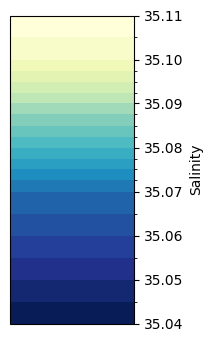

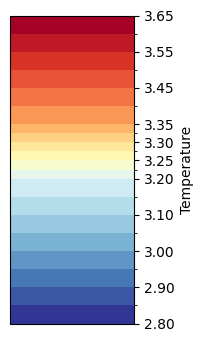

In [4]:
# Salinity segment boundaries: [ 0.101, 34.874, 34.881, 34.884, 34.886, 34.893, 34.913, 34.917, 34.920, 34.929, 35.406, ]
import numpy as np

def add_intermediate_levels(boundaries, n=1):
    """
    Add evenly spaced intermediate levels between existing boundaries.

    Parameters
    ----------
    boundaries : array-like
        Monotonic 1-D array of bin edges.
    n : int, default=1
        Number of intermediate points to insert between each pair.

    Returns
    -------
    new_boundaries : np.ndarray
        Array with intermediate points included.
    """
    boundaries = np.asarray(boundaries, dtype=float)
    new_bounds = [boundaries[0]]
    for a, b in zip(boundaries[:-1], boundaries[1:]):
        mids = np.linspace(a, b, n + 2)[1:-1]  # drop the endpoints
        new_bounds.extend(mids)
        new_bounds.append(b)
    return np.array(new_bounds)

dsalt=.05
# make nonlinear edges (e.g., packed around 35.0–35.1)
salt_boundaries = np.array([35.04, 35.05, 35.06, 35.07, 35.075, 35.08,35.085,  35.09, 35.095, 35.1, 35.11])
salt_boundaries = add_intermediate_levels(salt_boundaries)
salt_ticks = np.array([35.04, 35.05, 35.06, 35.07, 35.08, 35.09, 35.1, 35.11])
temp_boundaries = [2.8, 2.9, 3.0, 3.1, 3.2, 3.25, 3.3, 3.35, 3.45, 3.55, 3.65]
temp_ticks = temp_boundaries
temp_boundaries = add_intermediate_levels(temp_boundaries)

_ = nonlinear_colormap("YlGnBu_r", boundaries=salt_boundaries, ticks=salt_ticks, label="Salinity", show=True)
_ = nonlinear_colormap("RdYlBu_r", boundaries=temp_boundaries, ticks=temp_ticks, label="Temperature", show=True)

smin = 36.84
smax = 37.04
dsig = .02
sigma_levels = np.linspace(smin, smax, int(round((smax - smin)/dsig)) + 1)

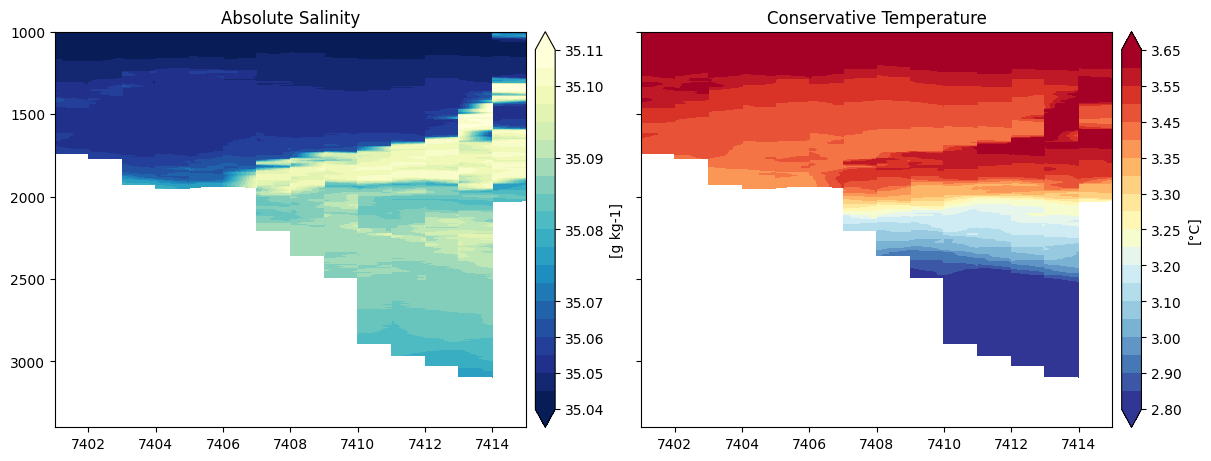

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True, constrained_layout=True)
# use the SAME boundaries in the section plot
if 1:
    section_plot(
        ds1, "SA", ax=axes[0],
        profile_dim="N_PROF", vertical_dim="N_LEVELS", pressure_var="pressure",
        x_axis="cast",
        cmap="YlGnBu_r",
        levels=salt_boundaries,          # <-- key bit
        cbar_ticks=salt_ticks,           # optional nice ticks
        sigma2_var="sigma2", sigma_label=True,
        sigma_levels = sigma_levels,
        debug=True,
        outside="extend", mode="contourf"
    )
# use the SAME boundaries in the section plot
section_plot(
    ds1, "CT", ax=axes[1],
    profile_dim="N_PROF", vertical_dim="N_LEVELS", pressure_var="pressure",
    x_axis="cast",
    cmap="RdYlBu_r",
    levels=temp_boundaries,          # <-- key bit
    cbar_ticks=temp_ticks,           # optional nice ticks
    sigma2_var="sigma2", sigma_label=True,
    sigma_levels = sigma_levels,
    debug=True,
    outside="extend",mode="contourf"
)
axes[1].set_title(ds1['CT'].attrs.get("long_name", "Conservative Temperature"))
axes[0].set_title(ds1['SA'].attrs.get("long_name", "Absolute Salinity"))
axes[0].invert_yaxis()
axes[0].set_ylim(3400,1000)

fig.savefig(f'../figures/m212_0{profile_id}_towyo.png')

## Till - can you make these profile plots interactive?

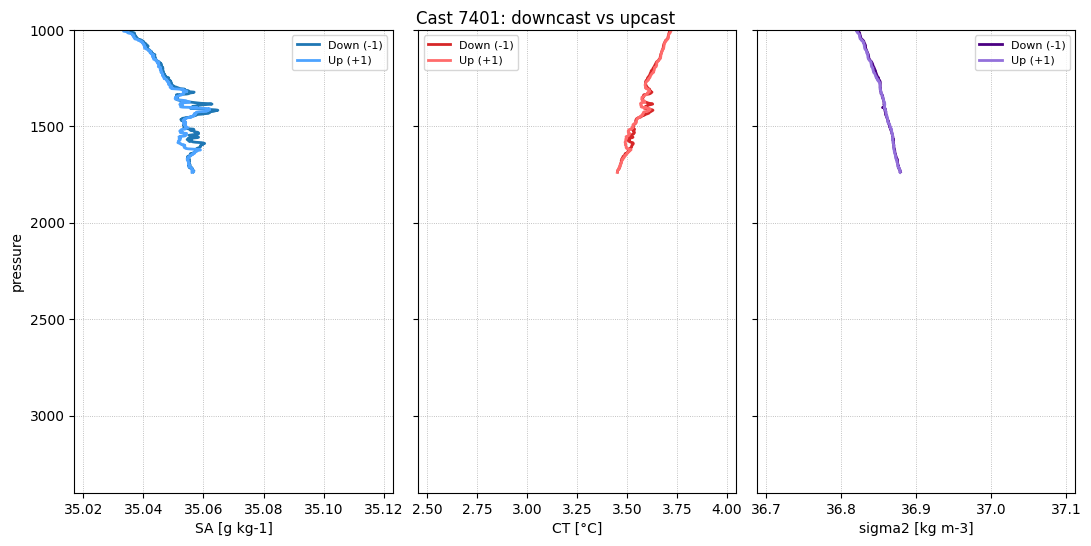

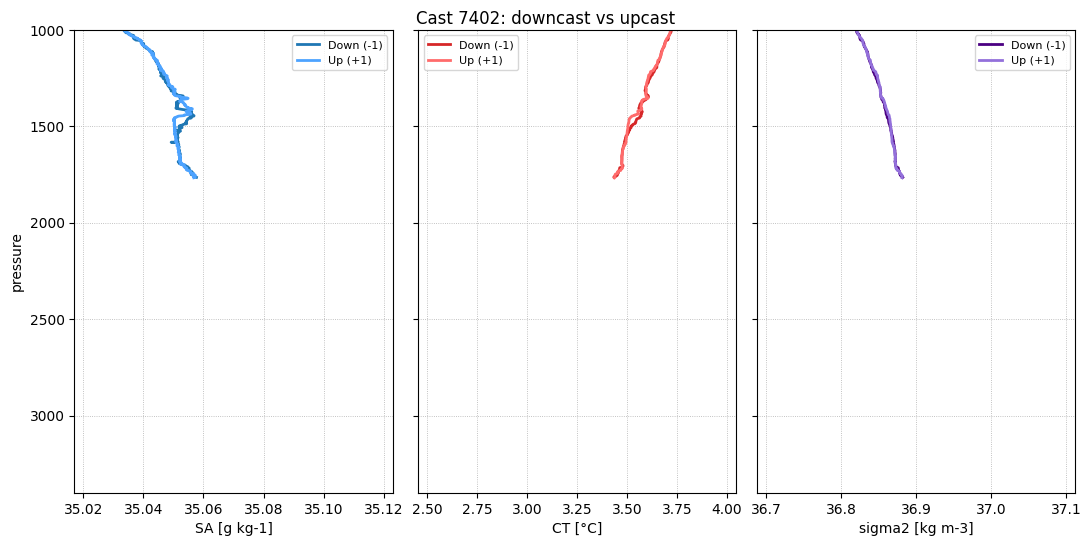

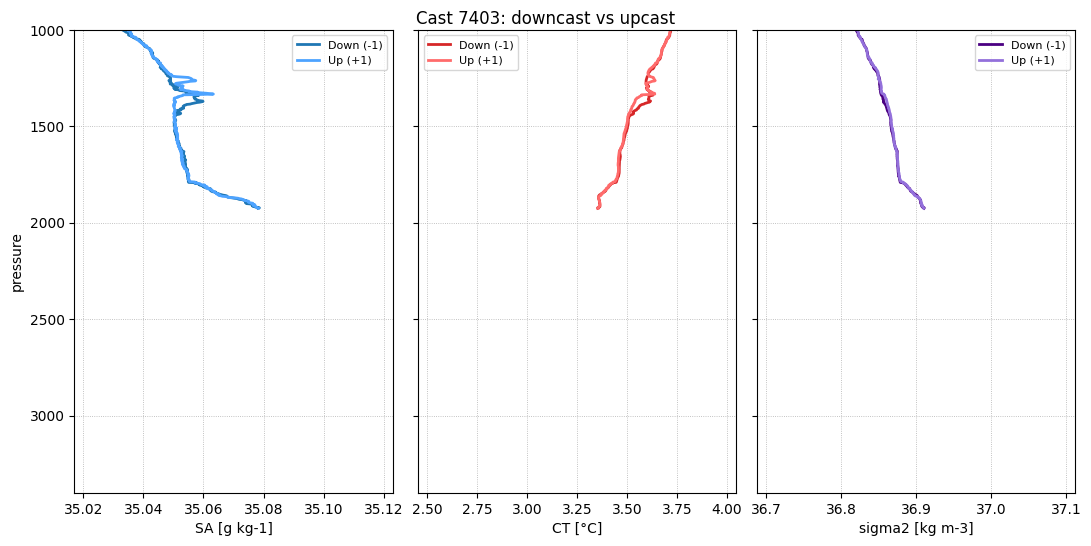

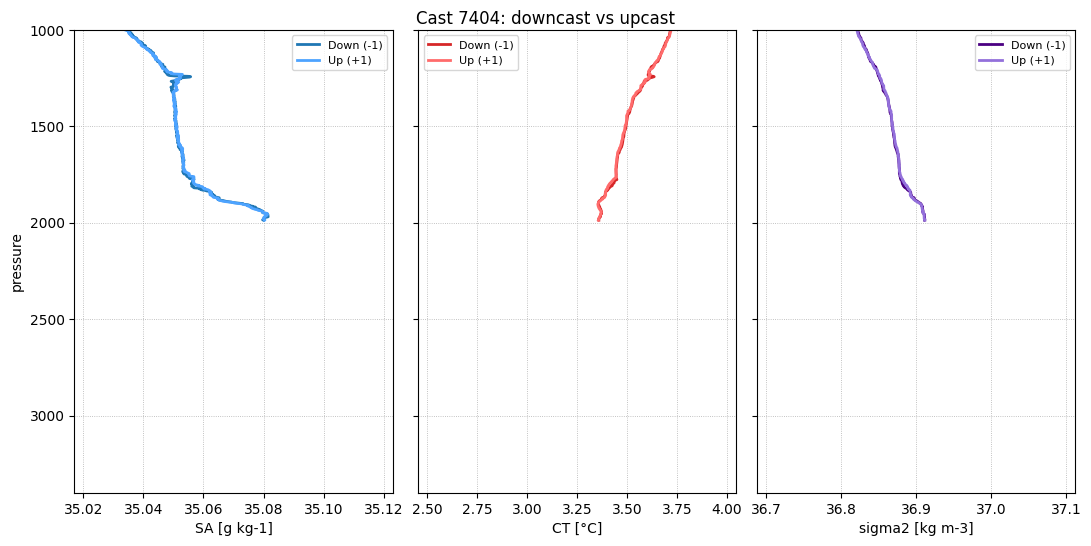

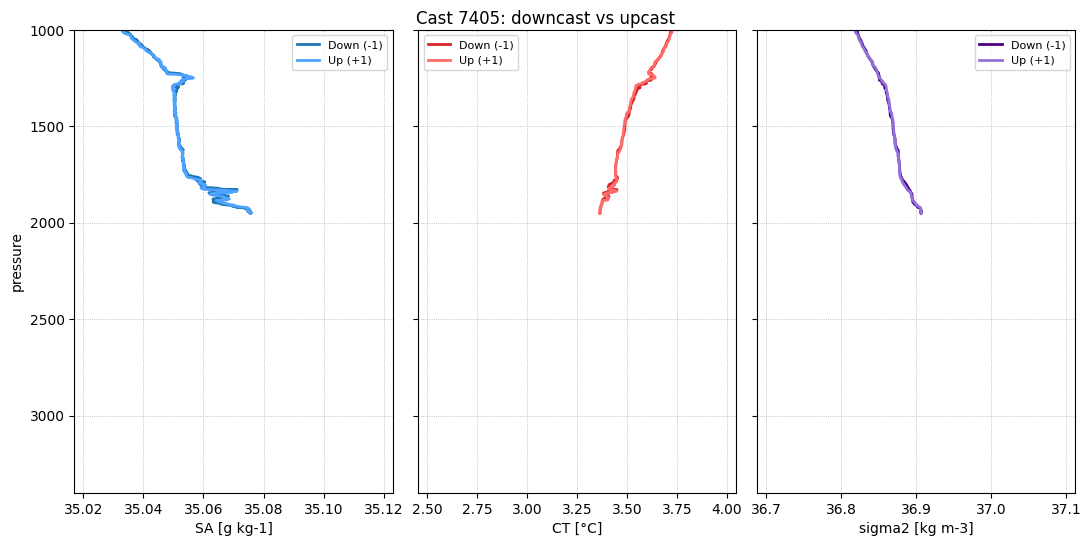

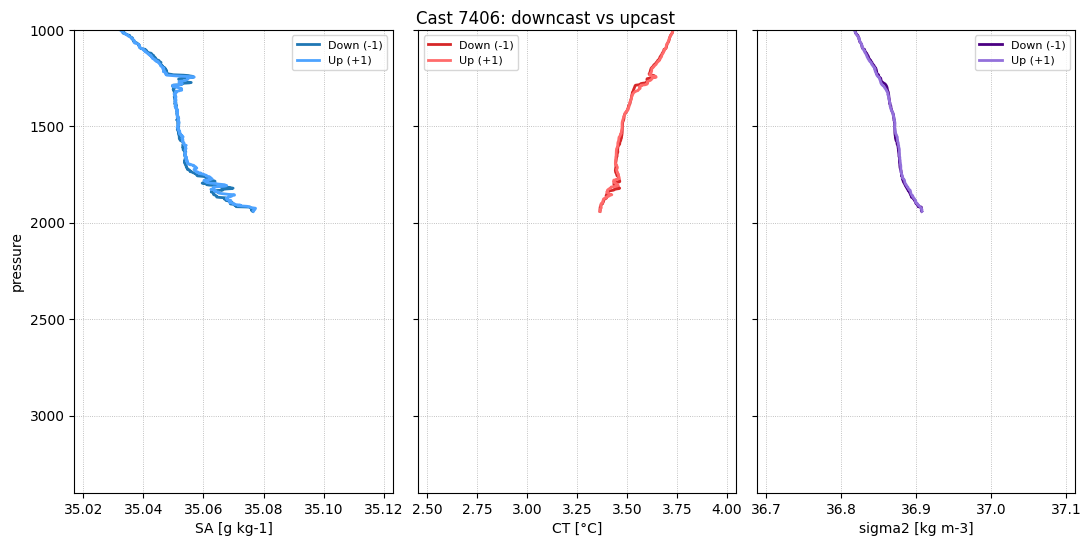

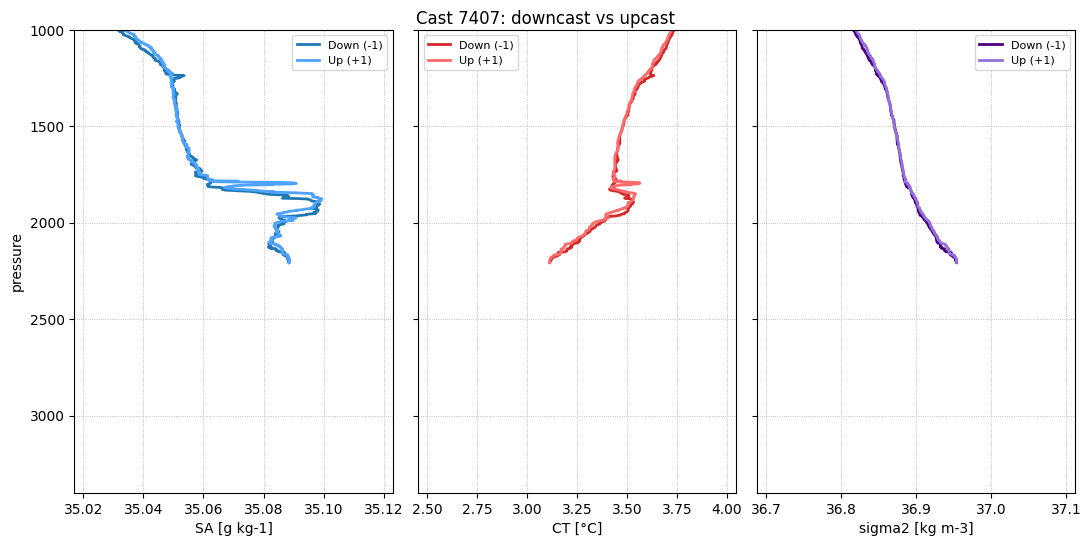

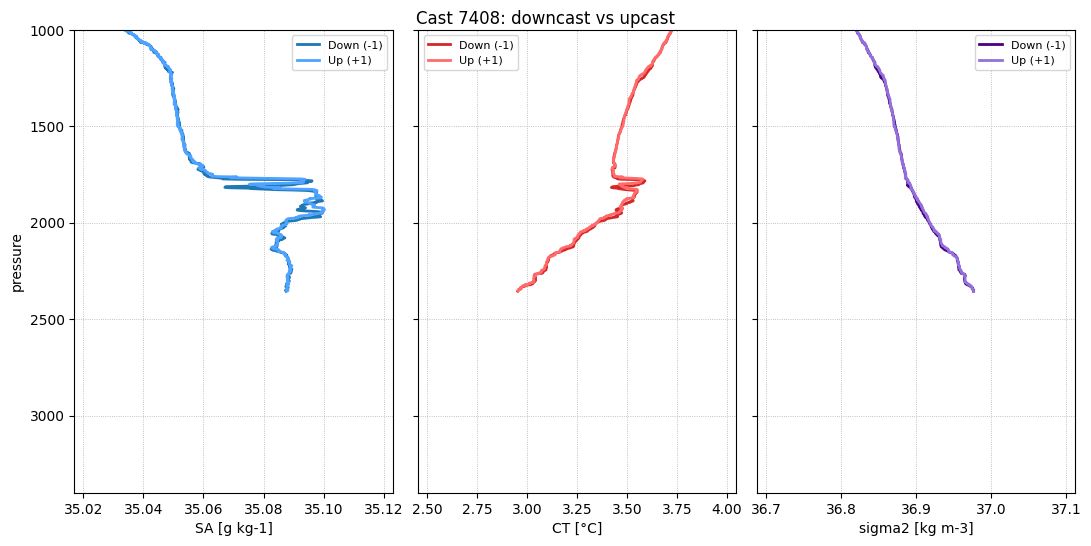

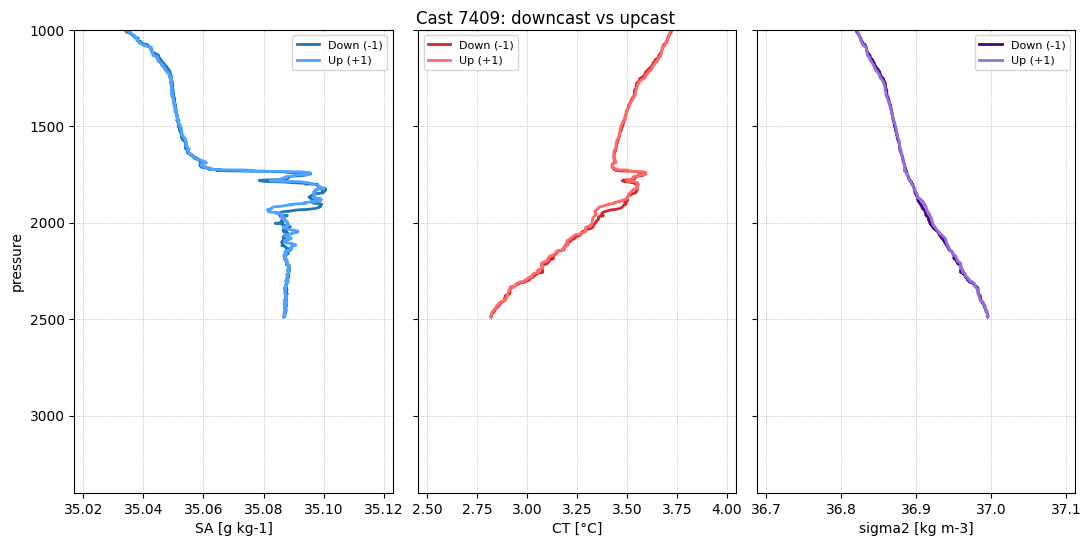

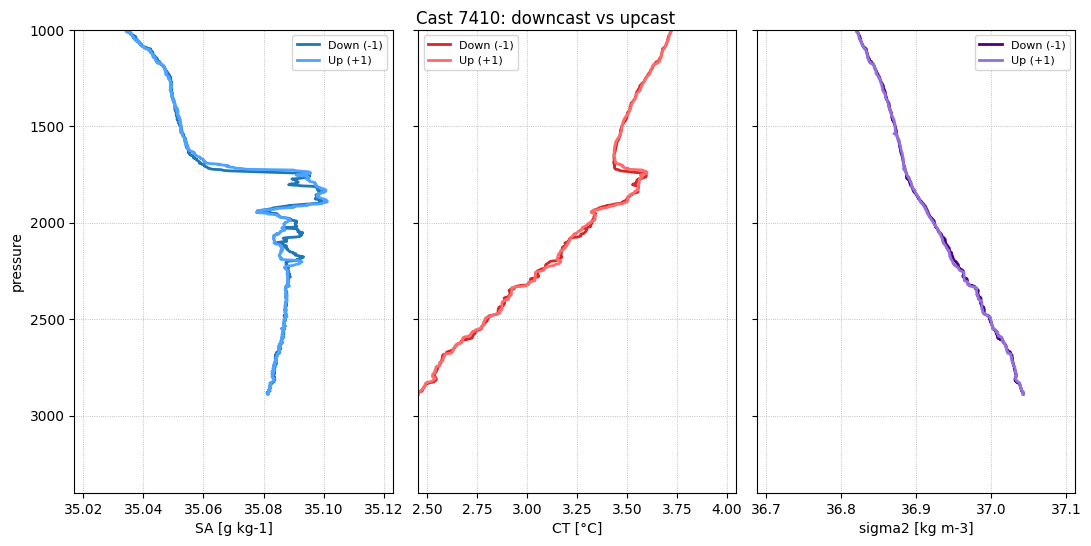

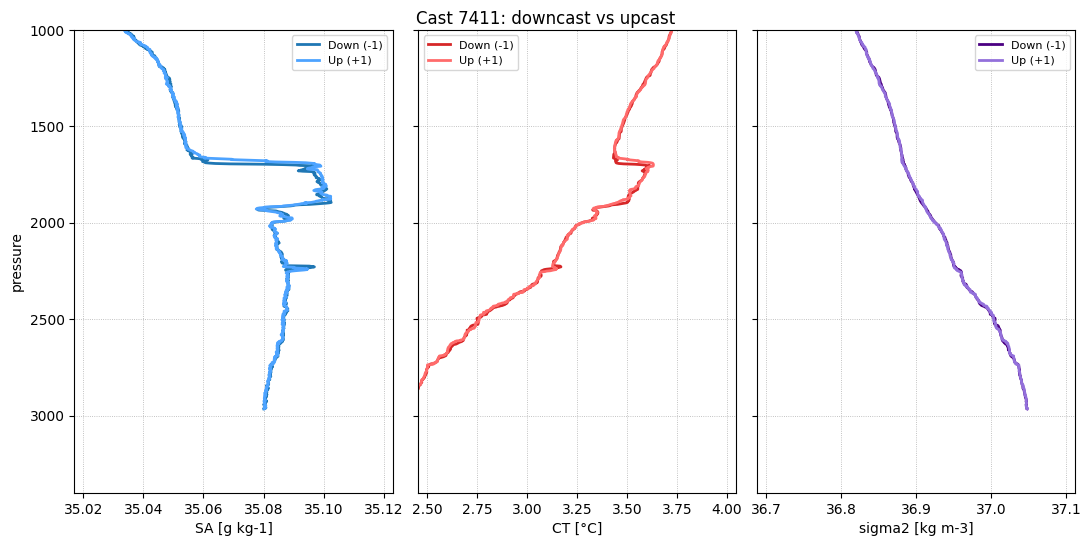

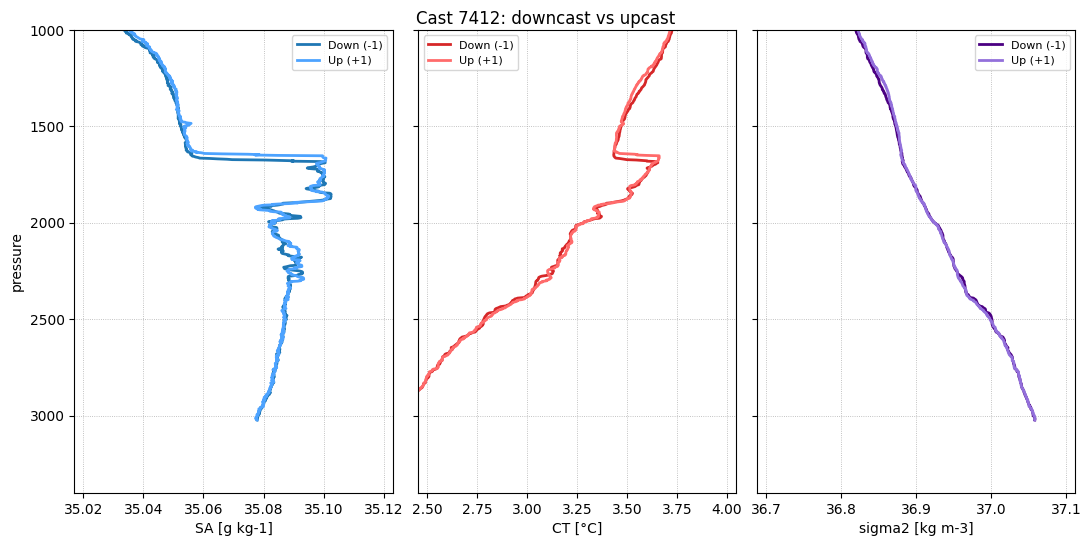

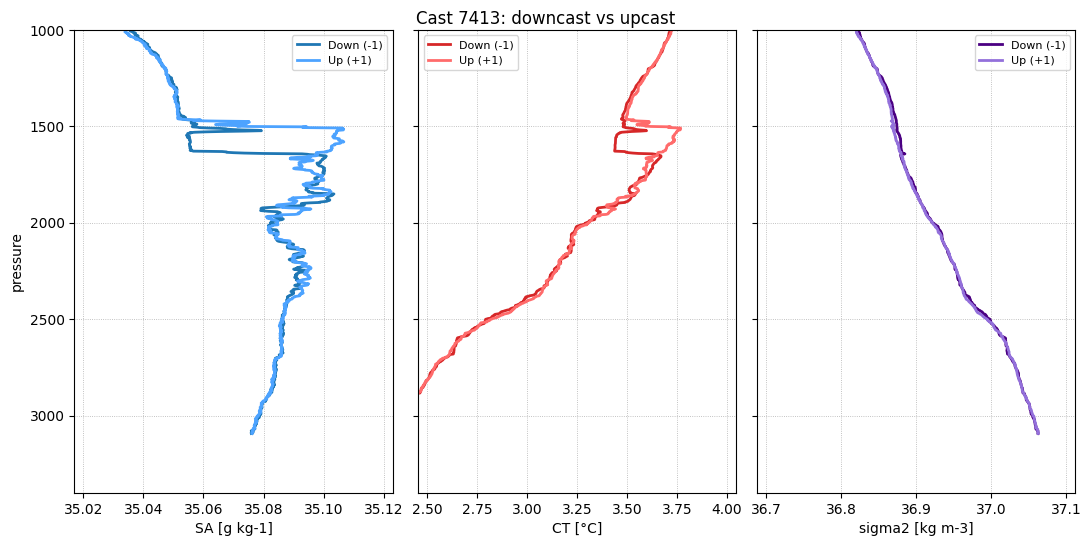

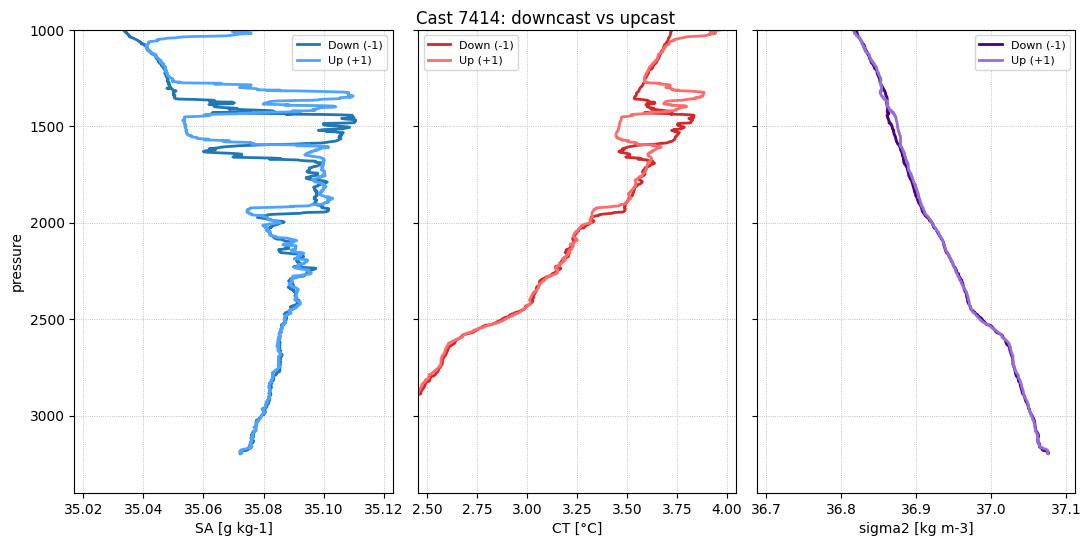

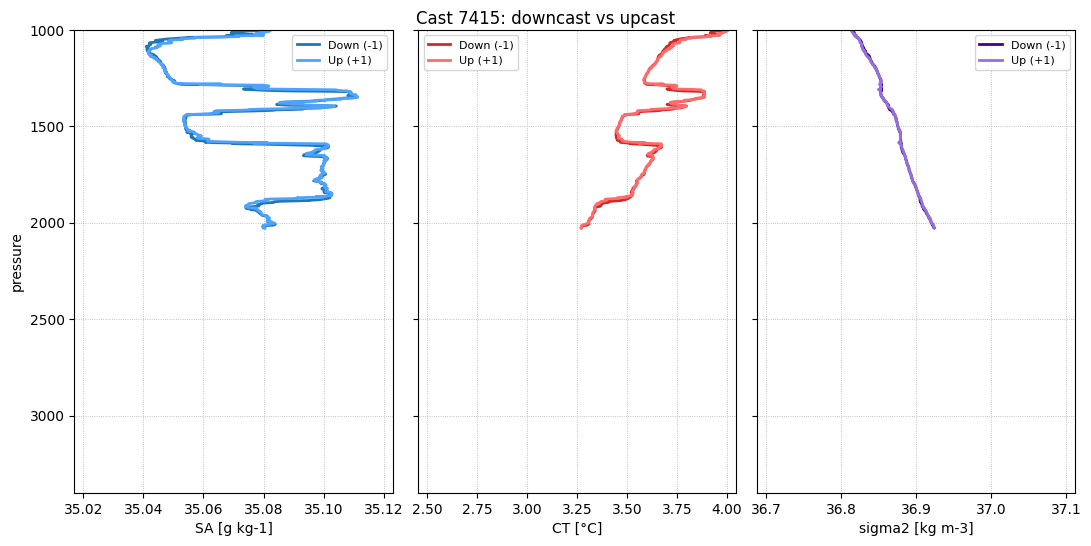

In [21]:
def plot_cast_profiles(
    ds: xr.Dataset,
    cast_number: int | float,
    vars_to_plot: list[str] | dict[str, tuple[float | None, float | None]],
    *,
    cast_var: str = "cast",
    updown_var: str = "updown",     # -1 = downcast, +1 = upcast
    pressure_var: str = "pressure",
    profile_dim: str = "N_PROF",
    vertical_dim: str = "N_LEVELS",
    y_limits: tuple[float, float] | None = None,
    nticks_x: int = 5,              # controls “nice” tick spacing when autosetting
):
    """
    Plot up to 4 variables for a single cast, with optional per-variable x-limits.

    vars_to_plot:
      - list[str]: variables; x-limits are computed smartly from data in y-range
      - dict[var] = (xmin, xmax): explicit x-limits for that variable
        Use None for either bound to fall back to smart limit for that side.
    """
    # --- helpers for “nice” limits (same as before) ---
    import math
    def _nice_num(x: float, round_: bool) -> float:
        if x <= 0 or not np.isfinite(x):
            return 1.0
        exp = math.floor(math.log10(x))
        f = x / (10 ** exp)
        if round_:
            nf = 1 if f < 1.5 else 2 if f < 3 else 5 if f < 7 else 10
        else:
            nf = 1 if f <= 1 else 2 if f <= 2 else 5 if f <= 5 else 10
        return nf * (10 ** exp)

    def nice_limits(xmin: float, xmax: float, nticks: int = 5, pad_frac: float = 0.03) -> tuple[float, float]:
        if not (np.isfinite(xmin) and np.isfinite(xmax)):
            return xmin, xmax
        if xmin == xmax:
            delta = 1.0 if xmin == 0 else abs(xmin) * 0.05
            xmin, xmax = xmin - delta, xmin + delta
        rng = xmax - xmin
        nice_rng = _nice_num(rng, round_=False)
        step = _nice_num(nice_rng / (nticks - 1), round_=True)
        lo = math.floor(xmin / step) * step
        hi = math.ceil (xmax / step) * step
        pad = max((hi - lo) * pad_frac, 0.0)
        return lo - pad, hi + pad

    # ---- input normalization: list → ordered list; dict → items with xlimits ----
    if isinstance(vars_to_plot, dict):
        items = list(vars_to_plot.items())
    else:
        if len(vars_to_plot) == 0:
            raise ValueError("Provide 1–4 variable names in vars_to_plot.")
        items = [(v, None) for v in vars_to_plot]
    if len(items) > 4:
        items = items[:4]

    # --- collapse helpers & index selection (unchanged) ---
    def _collapse_to_profile(da):
        arr = da
        if vertical_dim in da.dims:
            arr = da.isel({vertical_dim: 0})
        return np.asarray(arr.values).squeeze()

    cast_vals = _collapse_to_profile(ds[cast_var])
    updown_vals = _collapse_to_profile(ds[updown_var])

    idx_down = np.where((cast_vals == cast_number) & (updown_vals == -1))[0]
    idx_up   = np.where((cast_vals == cast_number) & (updown_vals == +1))[0]
    if idx_down.size == 0 and idx_up.size == 0:
        raise ValueError(f"No profiles found for cast={cast_number}.")
    idx_down = idx_down[0] if idx_down.size else None
    idx_up   = idx_up[0]   if idx_up.size   else None

    P = ds[pressure_var]
    def _pressure_for(j):
        return P.values if P.ndim == 1 else P.isel({profile_dim: j}).values

    def _kind(name: str) -> str:
        n = name.lower()
        if "sigma" in n: return "dens"
        if n.startswith("ct") or "temp" in n: return "temp"
        if n == "sa" or "salin" in n: return "salt"
        if "oxy" in n: return "oxy"
        return "other"

    colors = {
        "temp": ("#d62728", "#ff6b6b"),
        "salt": ("#1f77b4", "#4da3ff"),
        "oxy":  ("#8B4513", "#DEB887"),
        "dens": ("#4B0082", "#9370DB"),
        "other":("#555555", "#aaaaaa"),
    }

    n = len(items)
    fig, axes = plt.subplots(1, n, figsize=(3.6*n, 5.2), sharey=True, constrained_layout=True)
    if n == 1:
        axes = [axes]

    for ax, (var, xlim_override) in zip(axes, items):
        if var not in ds:
            ax.text(0.5, 0.5, f"{var} not found", ha="center", va="center", transform=ax.transAxes)
            continue

        k = _kind(var)
        c_down, c_up = colors[k]

        # DOWNCAST
        xs_in_view = []
        if idx_down is not None:
            x_down = ds[var].isel({profile_dim: idx_down}).values
            y_down = _pressure_for(idx_down)
            m = np.isfinite(x_down) & np.isfinite(y_down)
            ax.plot(x_down[m], y_down[m], color=c_down, lw=2, label="Down (-1)")

        # UPCAST
        if idx_up is not None:
            x_up = ds[var].isel({profile_dim: idx_up}).values
            y_up = _pressure_for(idx_up)
            m = np.isfinite(x_up) & np.isfinite(y_up)
            ax.plot(x_up[m], y_up[m], color=c_up, lw=2, label="Up (+1)")

        # Labels & grid
        units = ds[var].attrs.get("units", "")
        label = f"{var} [{units}]" if units else var
        ax.set_xlabel(label)
        ax.grid(True, linestyle=":", linewidth=0.6)
        ax.legend(loc="best", fontsize=8)

        # --- y-range & x-limits ---
        if y_limits is not None:
            ax.set_ylim(*y_limits)
        # Determine y-window for smart limits
        y0, y1 = ax.get_ylim()
        y_min, y_max = (min(y0, y1), max(y0, y1))

        # Compute smart range from data in view
        def _x_range_in_view():
            xviews = []
            if idx_down is not None:
                xv = ds[var].isel({profile_dim: idx_down}).values
                yv = _pressure_for(idx_down)
                m = np.isfinite(xv) & np.isfinite(yv) & (yv >= y_min) & (yv <= y_max)
                if np.any(m): xviews.append(xv[m])
            if idx_up is not None:
                xv = ds[var].isel({profile_dim: idx_up}).values
                yv = _pressure_for(idx_up)
                m = np.isfinite(xv) & np.isfinite(yv) & (yv >= y_min) & (yv <= y_max)
                if np.any(m): xviews.append(xv[m])
            if not xviews:
                return None, None
            xs = np.concatenate(xviews)
            return np.nanmin(xs), np.nanmax(xs)

        # Apply per-variable override if provided
        if isinstance(xlim_override, tuple) and len(xlim_override) == 2:
            xmin_smart, xmax_smart = _x_range_in_view()
            left  = xlim_override[0] if xlim_override[0] is not None else xmin_smart
            right = xlim_override[1] if xlim_override[1] is not None else xmax_smart
            if left is not None and right is not None:
                ax.set_xlim(*nice_limits(left, right, nticks=nticks_x))
            else:
                ax.autoscale(enable=True, axis='x', tight=True)
        else:
            # No override → smart limits
            xmin_smart, xmax_smart = _x_range_in_view()
            if xmin_smart is not None and xmax_smart is not None:
                ax.set_xlim(*nice_limits(xmin_smart, xmax_smart, nticks=nticks_x))
            else:
                ax.autoscale(enable=True, axis='x', tight=True)

    # y-axis
    axes[0].set_ylabel(pressure_var)
    axes[0].invert_yaxis()
    fig.suptitle(f"Cast {cast_number}: downcast vs upcast", y=1.02, fontsize=12)
    return fig, axes


castnum=7414
for castnum in np.unique(ds1.cast):
    # Plot SA, CT, sigma2, oxygen_1 for cast 7201, match your section y-range
    fig, axes = plot_cast_profiles(
        ds1, cast_number=castnum,
        vars_to_plot={
            "SA": (35.03, 35.11),
            "CT": (2.5, 3.8),
            "sigma2": (36.8, 37.1),
            # Optional: leave a side as None to auto on that side
            # "oxygen_1": (None, 320)  # smart min, fixed max
        },
        y_limits=(1000, 3400),
        nticks_x=6
    )

/Users/eddifying/Cloudfree/github/m212-atsea/m212_atsea/oceanplots.py:385: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nprof = ds.dims[profile_dim]


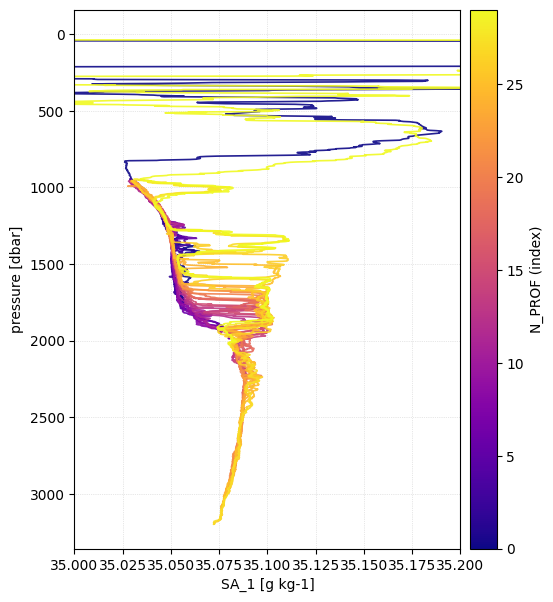

In [22]:
fig, ax = plt.subplots(figsize=(6, 7))
profile_plot(
    ds1, "SA_1",
    ax=ax,
    profile_dim="N_PROF",        # whatever your profile dimension is called
    vertical_dim="N_LEVELS",         # or "level", etc.
    pressure_var="pressure",      # name in your ds_all
    cmap="plasma",
)
ax.set_xlim(35, 35.2)
plt.show()
